In [1]:
import xarray as xr
import dask
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import glob
import pandas as pd
import os
import cartopy.crs as ccrs
import numpy as np
import pandas as pd


def spatial_mean(da):
    """Computes the spatial mean if lat and lon dimensions are present."""
    if 'lat' in da.dims and 'lon' in da.dims:
        return da.mean(dim=['lat', 'lon'])
    return da

# Convert cftime.DatetimeNoLeap to numpy.datetime64
def convert_time(ds):
    ds['time'] = [pd.Timestamp(time.strftime()) for time in ds['time'].values]
    return ds


#  Understand land surface data
##  1.  Load the landsurface data

In [2]:
fsurdat: str = "/home/jguo/projects/cesm/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_c190214.nc"
# Load the dataset
ds_sur = xr.open_mfdataset(fsurdat)
ds_sur

<xarray.Dataset>
Dimensions:                  (lsmlat: 192, lsmlon: 288, nlevsoi: 10,
                              natpft: 15, cft: 2, time: 12, lsmpft: 17,
                              numurbl: 3, numrad: 2, nlevurb: 5, nglcecp1: 11,
                              nglcec: 10)
Coordinates:
  * natpft                   (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft                      (cft) int32 15 16
  * time                     (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: lsmlat, lsmlon, nlevsoi, lsmpft, numurbl,
                                numrad, nlevurb, nglcecp1, nglcec
Data variables: (12/81)
    mxsoil_color             int32 ...
    SOIL_COLOR               (lsmlat, lsmlon) int32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    PCT_SAND                 (nlevsoi, lsmlat, lsmlon) float64 dask.array<chunksize=(10, 192, 288), meta=np.ndarray>
    PCT_CLAY                 (nlevsoi, lsmlat, lsmlon) float64 dask.array<chunksize=(10, 192, 288), meta=np.ndarray>
    ORGANIC                  (nlevsoi, lsmlat, lsmlon) float64 dask.array<chunksize=(10, 192, 288), meta=np.ndarray>
    FMAX                     (lsmlat, lsmlon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    ...                       ...
    CONST_HARVEST_SH2        (lsmlat, lsmlon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    CONST_HARVEST_SH3        (lsmlat, lsmlon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    CONST_GRAZING            (lsmlat, lsmlon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    CONST_FERTNITRO_CFT      (cft, lsmlat, lsmlon) float64 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    UNREPRESENTED_PFT_LULCC  (natpft, lsmlat, lsmlon) float64 dask.array<chunksize=(15, 192, 288), meta=np.ndarray>
    UNREPRESENTED_CFT_LULCC  (cft, lsmlat, lsmlon) float64 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                          NCAR-CSM
    History_Log:                          created on: 02-14-19 10:18:19
    Logname:                              erik
    Host:                                 cheyenne3
    Source:                               Community Land Model: CLM5
    Version:                              release-clm5.0.18/gpfs/fs1/scratch/...
    ...                                   ...
    map_vic_file:                         map_0.9x1.25_GRDC_to_0.9x1.25_nomas...
    Soil_texture_raw_data_file_name:      mksrf_soitex.10level.c010119.nc
    Soil_color_raw_data_file_name:        mksrf_soilcolor_CMIP6_simyr2005.c17...
    Fmax_raw_data_file_name:              mksrf_fmax_3x3min_USGS_c120911.nc
    Organic_matter_raw_data_file_name:    mksrf_organic_10level_5x5min_ISRIC-...
    Vegetation_type_raw_data_filename:    mksrf_landuse_histclm50_LUH2_2000.c...

##  2. Assign coordinate value to be actual lat and lon degree not the index

In [3]:
# Extract a column of unique latitudes and a row of unique longitudes as raw arrays
unique_lats = ds_sur['LATIXY'].isel(lsmlon=0).data  # Extracting the raw array for latitudes
unique_lons = ds_sur['LONGXY'].isel(lsmlat=0).data  # Extracting the raw array for longitudes

# Assign these raw arrays as 1D coordinates
ds_sur = ds_sur.assign_coords(lat=('lsmlat', unique_lats), lon=('lsmlon', unique_lons))


# Now, your DataArray or any variable extracted from ds_sur should have 1D lat and lon coordinates
total_urban_pct = ds_sur['PCT_URBAN']  # Example variable
print(total_urban_pct)

# At this point, the dataset dimensions will be based on actual latitude and longitude values


<xarray.DataArray 'PCT_URBAN' (numurbl: 3, lsmlat: 192, lsmlon: 288)>
dask.array<open_dataset-PCT_URBAN, shape=(3, 192, 288), dtype=float64, chunksize=(3, 192, 288), chunktype=numpy.ndarray>
Coordinates:
    lat      (lsmlat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    lon      (lsmlon) float64 dask.array<chunksize=(288,), meta=np.ndarray>
Dimensions without coordinates: numurbl, lsmlat, lsmlon
Attributes:
    long_name:  percent urban for each density type
    units:      unitless



##  3.  Determine which grid is Urban

In [4]:
# Access the PCT_URBAN variable
pct_urban = ds_sur['PCT_URBAN']
pct_urban


<xarray.DataArray 'PCT_URBAN' (numurbl: 3, lsmlat: 192, lsmlon: 288)>
dask.array<open_dataset-PCT_URBAN, shape=(3, 192, 288), dtype=float64, chunksize=(3, 192, 288), chunktype=numpy.ndarray>
Coordinates:
    lat      (lsmlat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    lon      (lsmlon) float64 dask.array<chunksize=(288,), meta=np.ndarray>
Dimensions without coordinates: numurbl, lsmlat, lsmlon
Attributes:
    long_name:  percent urban for each density type
    units:      unitless

In [5]:
# Sum across the 'numurbl' dimension to get total urban coverage

# https://bb.cgd.ucar.edu/cesm/threads/proportion-of-cities-in-surface-data.8046/
# PCT_URBAN is the percent of each urban density type. The density types in order are
# tall building district (TBD), high density (HD), and medium density (MD).
# If you change those percentages, e.g, increase them, then you'll need to decrease
# some other surface type (e.g., PCT_NATVEG, PCT_CROP, PCT_LAKE, etc.).
# The sum of PCT_URBAN, PCT_NATVEG, PCT_CROP, PCT_LAKE, PCT_GLACIER, PCT_WETLAND needs to be 100%.
# PCT_URBAN has multiple layers for different urban density types, sum across the 'numurbl' dimension to get total urban coverage
total_urban_pct = pct_urban.sum(dim='numurbl')
print(total_urban_pct)
total_urban_pct

<xarray.DataArray 'PCT_URBAN' (lsmlat: 192, lsmlon: 288)>
dask.array<sum-aggregate, shape=(192, 288), dtype=float64, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
    lat      (lsmlat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    lon      (lsmlon) float64 dask.array<chunksize=(288,), meta=np.ndarray>
Dimensions without coordinates: lsmlat, lsmlon


<xarray.DataArray 'PCT_URBAN' (lsmlat: 192, lsmlon: 288)>
dask.array<sum-aggregate, shape=(192, 288), dtype=float64, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
    lat      (lsmlat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    lon      (lsmlon) float64 dask.array<chunksize=(288,), meta=np.ndarray>
Dimensions without coordinates: lsmlat, lsmlon


##  4.  Create a mask for the urban grid, the mask is variable masked_urban_areas

In [6]:
# Use .where() to assign 1 to urban cells (where total urban percentage > 2%) and NaN to others
urban_grid_mask = total_urban_pct.where(total_urban_pct > 20, other=np.nan)

# Now, replace all non-NaN values (which indicate urban areas) with 1
# This is done by utilizing the np.where function from the numpy library to replace non-NaN (i.e., urban) values with 1
urban_grid_binary = xr.where(urban_grid_mask.notnull(), 1, urban_grid_mask)



def find_top_urban_areas(masked_urban_areas):
    # Convert the stacked DataArray to a pandas DataFrame
    df = masked_urban_areas.stack(z=('lsmlat', 'lsmlon')).to_dataframe(name='urban_pct')

    # Use the nlargest method on the DataFrame to find the top 50 values
    top_urban_areas_df = df.nlargest(50, 'urban_pct')
    # Drop the redundant 'lsmlat' and 'lsmlon' columns
    top_urban_areas_df = top_urban_areas_df.drop(columns=['lsmlat', 'lsmlon'])

    return top_urban_areas_df


# Call the function with the masked_urban_areas variable
top_urban_areas = find_top_urban_areas(urban_grid_mask)
print(top_urban_areas)

print( "percentage grid cells are urban:", urban_grid_mask.count().compute().item() * 100 / (192 * 288), "%")

# Rename dimensions in urban_grid_binary to match those in HW
# urban_grid_binary = urban_grid_binary.rename({'lsmlat': 'lat', 'lsmlon': 'lon'})
urban_grid_binary


                     lat     lon  urban_pct
lsmlat lsmlon                              
135    2       37.225131    2.50  55.611619
104    63       8.010471   78.75  50.000000
132    28      34.397906   35.00  48.645890
59     21     -34.397906   26.25  41.867101
58     243    -35.340314  303.75  40.578987
90     9       -5.183246   11.25  36.724269
133    112     35.340314  140.00  35.587411
140    25      41.937173   31.25  35.364088
128    25      30.628272   31.25  34.218028
104    58       8.010471   72.50  34.168117
139    2       40.994764    2.50  33.720860
132    282     34.397906  352.50  33.393325
107    59      10.837696   73.75  33.333333
140    218     41.937173  272.50  33.317939
116    58      19.319372   72.50  32.948605
95     223     -0.471204  278.75  30.613177
151    3       52.303665    3.75  30.387382
150    0       51.361257    0.00  29.279365
131    193     33.455497  241.25  28.873214
149    0       50.418848    0.00  27.881184
109    223     12.722513  278.75

<xarray.DataArray 'PCT_URBAN' (lsmlat: 192, lsmlon: 288)>
dask.array<where, shape=(192, 288), dtype=float64, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
    lat      (lsmlat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    lon      (lsmlon) float64 dask.array<chunksize=(288,), meta=np.ndarray>
Dimensions without coordinates: lsmlat, lsmlon


##  5.  Plot the urban grid

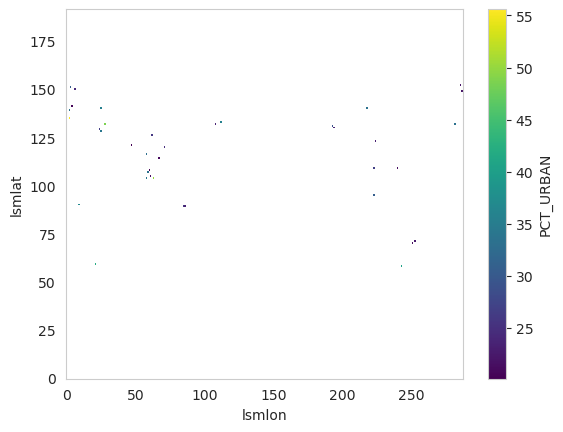

In [7]:
urban_grid_mask.plot()

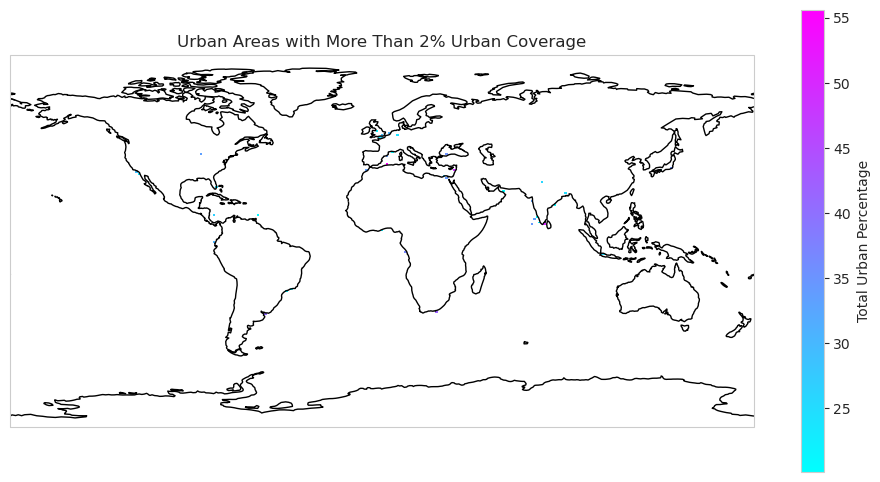

In [8]:
# Plotting
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Get longitude and latitude information from the dataset
longitude = ds_sur['LONGXY']
latitude = ds_sur['LATIXY']

# Plotting the urban areas that meet the condition
# Note: masked_urban_areas already has values below 2% filtered out, so we use it directly
plt.pcolormesh(longitude, latitude, urban_grid_mask, transform=ccrs.PlateCarree(), cmap='cool') #cmap='cool') cmap='Reds')

plt.colorbar(label='Total Urban Percentage')
plt.title('Urban Areas with More Than 2% Urban Coverage')
plt.show()


#  Define HW Temporal filter
##  1.  Load the daily(h1 tape) simulation temperature data

Load the dataset, I copied the daily h1 files to /home/jguo/process_data/i.e215.I2000Clm50SpGs.hw_production.02/daily_raw it is 137G in total
I run the utils/extrac_hw_data.py to extract the subset of variables from the above directory
and save the data to /home/jguo/process_data/i.e215.I2000Clm50SpGs.hw_production.02/summary

In [9]:
hw_summary_dir = '/home/jguo/process_data/i.e215.I2000Clm50SpGs.hw_production.02/summary'
hw_output_file = 'i.e215.I2000Clm50SpGs.hw_production.02.clm2.h1.hw.nc'
hw_out_file_path = os.path.join(hw_summary_dir, hw_output_file)
#check if hw_file exists
hw_file_exist = os.path.isfile(hw_out_file_path)


##  2   For each grid cell the find time periods that satisfy the HW definition. 

We use the definition from the US National Weather Service (NWS): three or more consecutive days of maximumtemperature reaching at least 90 ◦F (32.2 ◦C). 
We consider that, in each grid cell (a size on the order of 100 × 100 km), its rural sub-grid represents a local background environment for the city. 
Therefore, for each city we use its rural 2m-height temperature (T2m,rural) to define HWs.

We use this variable in the daily h1 file: TREFMXAV_R:long_name = "Rural daily maximum of average 2-m temperature" ;

In [10]:

#if hw_file does not exist, then we need to run the following code to create the hw_file
if not hw_file_exist:
    # Open the NetCDF file containing the rural daily maximum of average 2-m temperature
    hw_input_file = 'i.e215.I2000Clm50SpGs.hw_production.02.clm2.h1.TSA_UR_TREFMXAV_R.nc'
    hw_input_file_path = os.path.join(hw_summary_dir, hw_input_file)
    ds_hw = xr.open_dataset(hw_input_file_path)
    ds_hw
    # Define the threshold temperature in Kelvin
    # Convert 90 degrees Fahrenheit to Kelvin
    fahrenheit_threshold = 90
    kelvin_threshold = (fahrenheit_threshold - 32) * (5/9) + 273.15

    # Define a function to apply on each grid cell to detect heatwaves
    def detect_heatwave(tsa_r_np):
        # Ensure tsa_r_np is a 1D array for simplicity
        tsa_r_np = np.atleast_1d(tsa_r_np)
        hw = np.full(tsa_r_np.shape, np.nan)  # Initialize HW with NaN

        # Check for heatwaves
        for i in range(2, len(tsa_r_np)):
            if (tsa_r_np[i-2] > kelvin_threshold and
                    tsa_r_np[i-1] > kelvin_threshold and
                    tsa_r_np[i] > kelvin_threshold):
                hw[i-2:i+1] = 1  # Mark all three days as heatwave

        return hw

    # Use apply_ufunc to apply the detect_heatwave function across the dataset
    hw = xr.apply_ufunc(
        detect_heatwave, ds_hw['TSA_R'],
        input_core_dims=[['time']],  # Specify the core dimension
        output_core_dims=[['time']],  # Ensure output has the same core dimension as input
        vectorize=True,  # Enable broadcasting and looping over other dimensions
        output_dtypes=[float]  # Specify the output data type
    )
    # Optional: save the modified dataset to a new NetCDF file
    # Assign the HW data back to the original dataset as a new variable
    ds_hw['HW'] = hw
    # ds_hw.to_netcdf('hw_file_path')   
else:
    # Load the existing HW data
    ds_hw =xr.open_dataset(hw_out_file_path)
    hw = ds_hw['HW']    

print(hw)
hw


<xarray.DataArray 'HW' (lat: 192, lon: 288, time: 10951)>
[605546496 values with dtype=float64]
Coordinates:
  * time     (time) object 1985-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0


<xarray.DataArray 'HW' (lat: 192, lon: 288, time: 10951)>
[605546496 values with dtype=float64]
Coordinates:
  * time     (time) object 1985-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0


##  3.  The outcome should be 2D array with 1 for HW day and 0 for non HW day, the xarray should daily time dimension.

In [12]:
#todo read hw from the output file hw_file_path
hw

<xarray.DataArray 'HW' (lat: 192, lon: 288, time: 10951)>
[605546496 values with dtype=float64]
Coordinates:
  * time     (time) object 1985-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0


##  4.  Interecting the HW grid with the Urban grid, we can find the HW days for each urban grid

In [21]:


print(hw.lon.equals(urban_grid_binary.lon))
print(hw.lat.equals(urban_grid_binary.lat))

print(type(urban_grid_binary.lon))
print(type(hw.lon))
print('\nurban_grid_binary.lon:\n', urban_grid_binary.lon, '\n')
print("hw.lon:\n", hw.lon, '\n')

False
False
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>

urban_grid_binary.lon:
 <xarray.DataArray 'lon' (lsmlon: 288)>
dask.array<getitem, shape=(288,), dtype=float64, chunksize=(288,), chunktype=numpy.ndarray>
Coordinates:
    lon      (lsmlon) float64 dask.array<chunksize=(288,), meta=np.ndarray>
Dimensions without coordinates: lsmlon 

hw.lon:
 <xarray.DataArray 'lon' (lon: 288)>
array([  0.  ,   1.25,   2.5 , ..., 356.25, 357.5 , 358.75], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    long_name:  coordinate longitude
    units:      degrees_east 


In [22]:
# Intersect the HW data with the urban mask
hw_urban = xr.where(urban_grid_binary == 1, hw, np.nan)
hw_urban

<xarray.DataArray (lsmlat: 192, lsmlon: 288, lat: 192, lon: 288, time: 10951)>
dask.array<where, shape=(192, 288, 192, 288, 10951), dtype=float64, chunksize=(192, 288, 192, 288, 10951), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1985-01-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: lsmlat, lsmlon

In [26]:
print(hw_urban)
hw_urban.isel(time=0).drop(['time'])

<xarray.DataArray (lsmlat: 192, lsmlon: 288, lat: 192, lon: 288, time: 10951)>
dask.array<where, shape=(192, 288, 192, 288, 10951), dtype=float64, chunksize=(192, 288, 192, 288, 10951), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1985-01-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: lsmlat, lsmlon


<xarray.DataArray (lsmlat: 192, lsmlon: 288, lat: 192, lon: 288)>
dask.array<getitem, shape=(192, 288, 192, 288), dtype=float64, chunksize=(192, 288, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: lsmlat, lsmlon


###  4.1 make sure we do north and south hemisphere correctly
##  5. Compute the "HW days for Any grid" list of dates. I need to load file on that day if any grid has a HW day.  

In [25]:
# Check when HW == 1 for any grid cell and reduce the data array to a 1D time series
heatwave_days = hw_urban.any(dim=('lat', 'lon')).compute() #reduce the data array to a 1D time series

# Extract the dates where the condition is True
heatwave_dates = hw_urban['time'].where(heatwave_days, drop=True)

# Print the dates
print(heatwave_dates.values)

MemoryError: Unable to allocate 244. TiB for an array with shape (192, 288, 192, 288, 10951) and data type float64

In [ ]:
# Count the number of HW days
num_hw_days = heatwave_dates.size

print("Number of Heatwave Days:", num_hw_days)


###  5.1  further descrease that list by 


#  Process hourly simulation output data
##  1. Load the hourly simulation temperature data from "HW days for Any grid" list of dates
##  2. Convert UTC to local time 
##  3. Compute the UHI for 2m air T for each HW grid
##  4. Compute the UWBI for surface for each HW grid

#  Analyzing outcomes, figuring out what are the factors that is driving the UHI and UWBI
##  1.  feature engineering, the right hand side factors
###  1.1  humidity(precipitation))
###  1.2  distance to shore (what about big lakes)?
###  1.3  Different part of day (morning, afternoon, evening, night)
###  1.4  Surface roughness, albedo, vegetation

